In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image as im, ImageFont, ImageDraw
import cv2 as cv
from pprint import pprint 
import os
from tqdm import tqdm
from multiprocessing import Pool
import time


import warnings
warnings.filterwarnings("ignore")

### cette fonction permet d'éliminer l'espace qui ne contient pas de lettres pour ne garder que le mot

In [2]:
def trimSpace(img,spaceColor):
    for j in range(img.shape[1]-2):
        if((img[:,j+1:] == np.ones(img[:,j+1:].shape)*spaceColor).all()):
            img = img[:,:j+1]
    for i in range(img.shape[0]-2):
        if((img[i+1:,:] == np.ones(img[i+1:,:].shape)*spaceColor).all()):
            img = img[:i+1,:]
    
    for i in range(img.shape[0]-1,1,-1):
        if((img[i::-1,:] == np.ones(img[i::-1,:].shape)*spaceColor).all()):
            img = img[i:,:]
    return img

### en utilisant Pillow, on va générer les imagetes des mots qu'on cherche en utilisant le multiprocessing pour gagner du temps de calcul

In [3]:
def coreGenerateImages(args):
    imgs = []
    w,basePath,fontPath,conv,ext,s = args
    with im.open(basePath).convert(conv) as base:            
            #white bg black txt
            txtt = im.new(conv, base.size, (255,255,255,255))   #base.size = ((len(w)*15)+(len(w)*5),50)
            fnt = ImageFont.truetype(fontPath,s)
            d = ImageDraw.Draw(txtt)
            d.text((0,30),w,font=fnt,fill=(0,0,0,255))
            txtt.save(w+str(s)+"."+ext,ext.upper())            
            imm = cv.imread(w+str(s)+"."+ext)
            imm = trimSpace(imm,255) #trimWhitespace
            imgs.append(imm)
            os.remove(w+str(s)+"."+ext)
            """
            #black bg white txt
            txtt = im.new("RGB", base.size, (0,0,0,255))   #base.size = ((len(w)*15)+(len(w)*5),50)
            fnt = ImageFont.truetype(fontPath,s)
            d = ImageDraw.Draw(txtt)
            d.text((0,30),w,font=fnt,fill=(255,255,255,255))
            txtt.save(w+"2.jpg","JPEG")            
            imm = cv.imread(w+"2.jpg")
            imm = trimSpace(imm,0) #trimblackSpace
            imgs.append(imm)
            os.remove(w+"2.jpg")
            """
    return imgs

def generateImages(w,basePath,fontPath):
    
    if(basePath.find("png")!=-1):
        conv = "RGBA"
        ext = "png"
         
    elif(basePath.find("jpg")!=-1 or basePath.find("jpeg")!=-1):
        conv = "RGB"
        ext = "jpg"
    else:
        raise Exception("Unknown encoding type")
    
    sizes = [(w,basePath,fontPath,conv,ext,s) for s in range(8,40)]
    with Pool(100) as p:
        imgs = p.map(coreGenerateImages,sizes)
        
    return np.array(imgs).flatten()

### cette fonction calcule l'erreure quadratique entre deux images

In [4]:
def erreurQuad(test,orig):
    
    l,c = (orig.shape[0],orig.shape[1])
    N = (1/(l*c))
    return N * np.sum((orig-test)**2)


### comparer deux images pixel par pixel, si la différence de deux pixels est 0 ou bien en (valeur absolue)  < 30 (valeur trouvée après expérimentations)  alors ils sont les même, si le nombre des pixels qui sont égales (ou presque égales) est suppérieur au moitié du nombre total de tous les pixels alors on dirra que les deux images sont les même

In [5]:
def compareImgs(a,b):
    try:
        a = cv.cvtColor(a,cv.COLOR_RGB2GRAY)
        b = cv.cvtColor(b,cv.COLOR_RGB2GRAY)
    except:
        pass
    a=a.astype('double')
    b=b.astype('double')
    
    res = a-b

    res[res==0]=1
    res[np.abs(res)<30]=1
    
    t = res[res==1] 
    
    if(len(t)>(res.shape[0]*res.shape[1])/2):
        return True
    
    return False


### une fontion qui utilise erreureQuad et compareImgs et le PSNR pour comparer deux images, les valeurs indiqué sont trouvée après plusieurs expérimentations.

In [6]:
def findText3(im1,im2):
    
    
    im1 = cv.cvtColor(im1,cv.COLOR_RGB2GRAY)
    im2 = cv.cvtColor(im2,cv.COLOR_RGB2GRAY)
    
    res = cv.matchTemplate(im1,im2,cv.TM_SQDIFF)
    minV,maxV,minPos,maxPos = cv.minMaxLoc(res)
    w,h = (im2.shape[0],im2.shape[1])
    top_left = minPos    
    bottom_right = (top_left[0]+h,top_left[1]+w)
    
    
    
    #plt.imshow(im1[top_left[1]:top_left[1]+w,top_left[0]:top_left[0]+h])
    
    
    
    psnr=cv.PSNR(im1[top_left[1]:top_left[1]+w,top_left[0]:top_left[0]+h],im2)
    sqdif=erreurQuad(im1[top_left[1]:top_left[1]+w,top_left[0]:top_left[0]+h],im2)
    
    """
    zeros = im2 - im1[top_left[1]:top_left[1]+w,top_left[0]:top_left[0]+h]
    linearzeros = zeros.reshape(1,w*h)
    linearzeros = linearzeros[linearzeros==0]
    
    ones = im1[top_left[1]:top_left[1]+w,top_left[0]:top_left[0]+h].reshape(1,w*h)
    linearones = ones[ones==255]
    """
    
    #if(psnr>10.5 and sqdif<60 and (len(linearzeros)>((50*(w*h))/100) and len(linearones)<((50*(w*h))/100))):      
    #if(psnr>10.5 and sqdif<60 and isNbXInColsRowsGtP(zeros,0,20)):          
    if(compareImgs(im2,im1[top_left[1]:top_left[1]+w,top_left[0]:top_left[0]+h]) and psnr>12 and sqdif<70):
        imTmp = im1
        imTmp = cv.cvtColor(imTmp,cv.COLOR_GRAY2RGB)
        #cv.rectangle(imTmp,top_left,bottom_right,255,0)
        #plt.imsave("im"+str(int(psnr))+"_"+str(int(sqdif))+".png",imTmp)
        #plt.imshow(im1[top_left[1]:top_left[1]+w,top_left[0]:top_left[0]+h])
        coordinates = [top_left,bottom_right,w,h]
        return [True,coordinates]
        
    
    return [False,None,w*h,psnr,sqdif]
    #return [False,None]


### ici on compare une image avec une liste des images pour trouvée celle qui correspond le mieux à l'originale en utilisant le multiprocessing pour gagner du temps de calcul

In [7]:
def findTextV3Core(args):
        (doc,imgg) = args
        results=findText3(doc,imgg)
        return results
    
def findTextV3(doc,wordImages):

    wordims = [(doc,imm) for imm in wordImages ]
    
    with Pool(100) as p:
        ress = p.map(findTextV3Core,wordims)
    
    founds = []
    
    for r in ress:
        if(r[0]==True):
            founds.append(r)
    
    if(len(founds)>0):
        return [True,founds[0][1]]

    return [False,None]

### c'est la fonction principale qui fait appele au autres fonctions pour chercher si le mot text (si separateWords=False) ou bien la liste des mots de text (separateWords=True) existe ou non dans l'image dont le chemin est docPath en utilisant les polices (fonts) qui existent dans fontsPath

In [8]:
def bruteForceSearch(docPath,text,fontsPath,separateWords=True):
    
    doc = cv.imread(docPath)
    
    
    words = text.split(" ") if separateWords else [text]
    founds = [0]*len(words)
    coords = []
    
    
    # get list of fonts files names
    fonts = []
    
    #go to fonts dir    
    os.chdir(fontsPath)
    for elm in os.listdir():
        fonts.append(elm)
    
    # return to principal dir
    os.chdir("..")
    
    #for each word, for each font generate images and test
    
    
    """
    
    # on commence par le premier mot, si on le trouve alors tester les autres juste avec le font
    # de ce dernier, sinon arrêter car si un seul mot n'existe pas alors la phrase ou
    # le paragraphe n'existe pas
    
    
    winnerFont = ""
    
    for f in tqdm(fonts):
        pprint(f)
        images  = generateImages(words[0],docPath,fontsPath+"/"+f)    
        results = findTextV3(doc,images)
        if(results[0]):
            winnerFont = f            
            founds[0] = 1
            coords.append(results[1])
            break        
    if(winnerFont!=""):
        for i in tqdm(range(1,len(words))):            
            images = generateImages(words[i],docPath,fontsPath+"/"+winnerFont)                    
            results = findTextV3(doc,images)
            if(results[0]):
                founds[i] = 1
                coords.append(results[1])
            else:
                founds[i] = 0
                coords.append(None)
    else:
    """
    for i in tqdm(range(0,len(words))):        
        for f in tqdm(fonts):            
            images = generateImages(words[i],docPath,fontsPath+"/"+f)                    
            results = findTextV3(doc,images)
            if(results[0]):
                founds[i] = 1
                coords.append(results[1])
                break
    
            
        
    
    if(sum(founds) == len(founds)):
        res = True
    else:
        res = False
    
    return [res,coords,sum(founds),founds]
        
            
    

### pour afficher les résultats

In [9]:
def showResult(results,docPath):
    pprint(results)
    imTmp = cv.imread(docPath)
    for c in results[1]:
        if(c==None):
            continue
        cv.rectangle(imTmp,c[0],c[1],255,0)
    plt.imsave("Results.jpg",imTmp)
    plt.imshow(imTmp,cmap="gray")

### pour tester, telecharger le repository et tester avec les images dans le dossier imgs ou bien ajouter vos images. Si vous veuller chercher mot par mot alors remplacer False par True ou bien éliminer cet argument
### cette methode est compatible avec les documents ecrit en noir avec une background blanche, sinon (coleurs) il ne donne pas des résultats correctes.

### exemple :

In [10]:
results = bruteForceSearch("./imgs/test1.png","image segmentation Zhou Luu reinforcement Deep learning ELSEVIER Introduction ABSTRACT Medical","./Fonts",True)

100%|██████████| 11/11 [12:14<00:00, 66.80s/it] 


[False,
 [[(296, 77), (316, 86), 9, 20],
  [(167, 262), (219, 271), 9, 52],
  [(98, 272), (118, 280), 8, 20],
  [(263, 230), (276, 238), 8, 13],
  [(150, 403), (197, 412), 9, 47],
  [(424, 373), (444, 383), 10, 20],
  [(78, 414), (106, 423), 9, 28],
  [(370, 475), (411, 483), 8, 41],
  [(171, 763), (204, 772), 9, 33]],
 9,
 [1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1]]


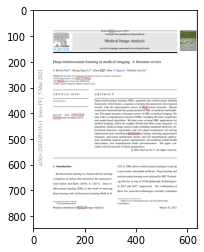

In [11]:
showResult(results,"./imgs/test1.png")